In [ ]:
import sys
import os
import sympy as sp
import numpy as np
import pandas as pd

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..')))
import setup_paths

from gauss_fehlerfortpflanzung import evaluate_gaussian_error
from gauss_fehlerfortpflanzung import gaussian_error_propagation
from geraden_fit import geraden_fit
from scientific_error_rounder import runden_und_speichern
from mean_calc_w_err import err_weighted_mean
from tabelle import tabellen_ersteller
from geraden_fit_config import config_1

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, ScalarFormatter

from decimal import Decimal, ROUND_HALF_UP, getcontext

def round_measurement(value, error):
    """
    Rundet einen Messwert und seinen Fehler wissenschaftlich korrekt.

    Parameter:
    - value (float): Messwert.
    - error (float): Fehler des Messwerts.

    Rückgabewert:
    - rounded_value_str (str): Gerundeter Messwert als String.
    - rounded_error_str (str): Gerundeter Fehler als String.
    """
    getcontext().prec = 28
    val_dec = Decimal(str(value))
    err_dec = Decimal(str(error))

    if err_dec == 0:
        rounded_err = Decimal('0')
        rounded_val = val_dec
        dp_err = None
        dp_val = None

    else:
        # Exponent des Fehlers bestimmen
        exp_e = err_dec.normalize().adjusted()
        m = err_dec.scaleb(-exp_e)
        first_digit = int(m.to_integral_value(rounding=ROUND_HALF_UP))
        if first_digit in [1, 2]:
            significant_digits = 2
        else:
            significant_digits = 1
        exponent_LSD = exp_e - (significant_digits - 1)
        # Fehler aufrunden
        factor_err = Decimal('1e{}'.format(exponent_LSD))
        rounded_err = (err_dec / factor_err).to_integral_value(rounding=ROUND_HALF_UP) * factor_err
        # Bestimmen der Anzahl der Dezimalstellen für Fehler
        dp_err = max(-exponent_LSD, 0)
        dp_val = dp_err  # Der Wert wird auf die gleiche Stelle wie der Fehler gerundet
        # Quantisierungswert erstellen
        quantize_exp = Decimal('1e{}'.format(exponent_LSD))
        # Gerundeten Fehler und Wert quantisieren
        rounded_err = rounded_err.quantize(quantize_exp)
        rounded_val = val_dec.quantize(quantize_exp, rounding=ROUND_HALF_UP)

    # Formatierung, um nachgestellte Nullen zu erhalten
    if dp_val is not None:
        format_str = f'{{0:.{dp_val}f}}'
        rounded_value_str = format_str.format(rounded_val)
    else:
        rounded_value_str = str(rounded_val)

    if dp_err is not None:
        format_str = f'{{0:.{dp_err}f}}'
        rounded_error_str = format_str.format(rounded_err)
    else:
        rounded_error_str = str(rounded_err)

    return rounded_value_str, rounded_error_str


def mean_calc(z_input, err_input, goal='data weighting'):
    """
    Berechnet den gewichteten Mittelwert eines Wertearrays unter Berücksichtigung individueller Fehlerwerte.

    Parameter:
    - z_input (array_like): Array mit den zu gewichtenden Werten.
    - err_input (array_like): Array mit den Fehlern, die den Werten in z_input zugeordnet sind.
    - goal (str, optional): Bestimmt den Berechnungsmodus.
        - 'data weighting': Berechnet den gewichteten Mittelwert der Daten.
        - 'error': Berechnet den Fehler des Mittelwerts.
        Standardwert: 'data weighting'

    Rückgabewert:
    - mean_val (float): Der berechnete gewichtete Mittelwert oder der Fehler des Mittelwerts.
    """
    mean_1 = mean_2 = i = 0
    while i < len(z_input):
        mean_1 += (z_input[i] / err_input[i] ** 2)
        mean_2 += (1 / (err_input[i] ** 2))
        i += 1
    if goal == 'data weighting':
        mean_val = mean_1 / mean_2
    if goal == 'error':
        mean_val = np.sqrt(1 / mean_2)
    return mean_val
    

def geraden_fit(exp_nr, file_n, title='Titel', x_label='X-Achse', y_label='Y-Achse',
                save=False, length=15, height=5, x_axis=0, y_axis=0, result_length=4, 
                x_major_ticks=None, x_minor_ticks=None, y_major_ticks=None, y_minor_ticks=None,
                legendlocation='best', y_labels=None, y_markers=None, y_colors=None, 
                x_decimal_places=1, y_decimal_places=1, scientific_limits=(-3,3), Ursprungsgerade=None, Malus=None, custom_datavol_limiter=0,
                linear_fit=False, focus_point=False, plot_y_inter = False, y_inter_label = None, x_shift = 0, y_shift = 0, plot_errors = True, size = 1):
                
    """
    Diese Funktion ermöglicht die Darstellung von Messdaten mit Fehlerbalken und optionaler linearer Regression.
    Sie unterstützt mehrere Datensätze und bietet vielfältige Anpassungsmöglichkeiten für die Visualisierung.

    Parameter:
    - exp_nr (int): Experimentnummer für die Zuordnung.
    - file_n (str): Name der Datei, die die Daten enthält.
    - title (str, optional): Titel des Plots. Standard: 'Titel'.
    - x_label (str, optional): Beschriftung der X-Achse. Standard: 'X-Achse'.
    - y_label (str, optional): Beschriftung der Y-Achse. Standard: 'Y-Achse'.
    - save (bool, optional): Ob der Plot gespeichert werden soll. Standard: False.
    - length (int, optional): Breite des Plots in Zoll. Standard: 15.
    - height (int, optional): Höhe des Plots in Zoll. Standard: 5.
    - x_axis (float, optional): Position der vertikalen Linie bei x=0. Standard: 0.
    - y_axis (float, optional): Position der horizontalen Linie bei y=0. Standard: 0.
    - result_length (int, optional): Rundung der Ergebnisse auf diese Anzahl Dezimalstellen. Standard: 4.
    - x_major_ticks (float, optional): Abstand zwischen den Hauptticks der X-Achse. Standard: None.
    - x_minor_ticks (float, optional): Abstand zwischen den Nebenticks der X-Achse. Standard: None.
    - y_major_ticks (float, optional): Abstand zwischen den Hauptticks der Y-Achse. Standard: None.
    - y_minor_ticks (float, optional): Abstand zwischen den Nebenticks der Y-Achse. Standard: None.
    - legendlocation (str, optional): Position der Legende. Standard: 'best'.
    - y_labels (list, optional): Bezeichnungen für die Y-Datensätze. Standard: None.
    - y_markers (list, optional): Marker für die einzelnen Datensätze. Standard: None.
    - y_colors (list, optional): Farben für die einzelnen Datensätze. Standard: None.
    - x_decimal_places (int, optional): Anzahl der Dezimalstellen auf der X-Achse. Standard: 1.
    - y_decimal_places (int, optional): Anzahl der Dezimalstellen auf der Y-Achse. Standard: 1.
    - Ursprungsgerade (float, optional): Erstellt Ursprungsgerade mit Steigung Ursprungsgerade
    - custom_datavol_limiter (int, optional): Begrenzung der Anzahl der Datenpunkte. Standard: 0 (keine Begrenzung).
    - linear_fit (bool, optional): Ob eine lineare Regression durchgeführt wird. Standard: False.
    - focus_point (bool, optional): Ob der Schwerpunkt mit Fehlerbalken dargestellt wird. Standard: False.
    - plot_y_inter (bool, optional): Ob der Y-Achsenabschnitt angezeigt wird. Standard: False.
    - y_inter_label (str, optional): Label für den Y-Achsenabschnitt. Standard: None.
    - x_shift (float, optional): Horizontaler Offset für die X-Daten. Standard: 0.
    - y_shift (float, optional): Vertikaler Offset für die Y-Daten. Standard: 0.
    - plot_errors (bool, optional): Ob Fehler auch geplotted werden. Standart: True

    Rückgabewert:
    - Ein Plot der Messdaten mit Fehlerbalken, optionalen Regressionslinien und weiteren Visualisierungen.
    """

    # Daten laden
    data = np.loadtxt(file_n, ndmin=1)
    x_val, x_err = data[:, 0] + x_shift, data[:, 1]
    y_data = data[:, 2:]
    
    # Überprüfen, ob die Anzahl der y-Spalten gerade ist
    if y_data.shape[1] % 2 != 0:
        raise ValueError("Die Anzahl der y-Spalten muss gerade sein (Paare von y und y_err).")
    
    n_datasets = y_data.shape[1] // 2  # Anzahl der y-Datensätze
    
    # Labels, Marker und Farben vorbereiten
    if y_labels is None:
        y_labels = [f'{i+1}' for i in range(n_datasets)]
    if y_markers is None:
        y_markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', '+', 'x', 'd']
    if y_colors is None:
        cmap = plt.cm.get_cmap('tab10')
        y_colors = [cmap(i) for i in range(n_datasets)]
    
    fig, ax = plt.subplots(figsize=(length, height))
    
    # Achsen bei x=0 und y=0 hinzufügen
    ax.axhline(y_axis, color='black', linewidth=1.5)
    ax.axvline(x_axis, color='black', linewidth=1.5)
    
    # Begrenzter Wertebereich für die Ursprungsgerade initialisieren
    overall_min_x = np.inf
    overall_max_x = -np.inf
    
    # Jeden Datensatz plotten
    for i in range(n_datasets):
        y_val = y_data[:, 2*i] + y_shift
        y_err = y_data[:, 2*i + 1]
    
        # Begrenzen der Daten, falls custom_datavol_limiter gesetzt ist
        limit = custom_datavol_limiter if custom_datavol_limiter > 0 else len(x_val)
        x_val_limited = x_val[:limit]
        x_err_limited = x_err[:limit]
        y_val_limited = y_val[:limit]
        y_err_limited = y_err[:limit]
    
        n = len(x_val_limited)
    
        if y_labels != '':
            label = y_labels[i] if i < len(y_labels) else f'Datensatz {i+1}'
        marker = y_markers[i % len(y_markers)]
        color = y_colors[i % len(y_colors)]
        if plot_errors == True:
            ax.errorbar(x_val_limited, y_val_limited, xerr=x_err_limited, yerr=y_err_limited,
                marker=marker, capsize=3, linestyle='none', label=label, color=color, markersize = size)
        else:
            ax.plot(x_val_limited, y_val_limited, marker=marker, linestyle='none', label=label, color=color, markersize = size)
    
        if linear_fit:
            # Berechnungen der Ausgleichsgeraden -unsicherheit und des Mittelwerts 
            x_mean = mean_calc(x_val_limited, y_err_limited)
            y_mean = mean_calc(y_val_limited, y_err_limited)
            xty_mean = mean_calc(x_val_limited * y_val_limited, y_err_limited)
            xs_mean = mean_calc(x_val_limited ** 2, y_err_limited)
            y_err_mean = mean_calc(y_val_limited, y_err_limited, 'error')
        
            

            grad = (xty_mean - x_mean * y_mean) / (xs_mean - x_mean ** 2)
            y_inter = (xs_mean * y_mean - x_mean * xty_mean) / (xs_mean - x_mean ** 2)
            xy_err_mean = np.mean((y_err * np.sqrt(((x_err / x_val)/(y_err / (y_val-y_inter)))**2 + 1))) # Beruecksichtigung des X-Fehlers für folgende Fehlerberechnung der Geradensteigung
            var_grad = xy_err_mean ** 2 / (n * (xs_mean - x_mean ** 2))
            var_inter = xy_err_mean ** 2 * xs_mean / (n * (xs_mean - x_mean ** 2))
    
            grad_err = np.sqrt(var_grad)
            y_inter_err = np.sqrt(var_inter)
    
            x_mean_err = np.sqrt(np.sum(x_err_limited**2)) / n  # Fehler des Mittelwerts
    
            # Gerundete Werte erhalten
            grad_str, grad_err_str = round_measurement(grad, grad_err)
            y_inter_str, y_inter_err_str = round_measurement(y_inter, y_inter_err)
            x_mean_str, x_mean_err_str = round_measurement(x_mean, x_mean_err)
            y_mean_str, y_mean_err_str = round_measurement(y_mean, y_err_mean)

            # Schwerpunkt plotten
            if focus_point:
                if plot_errors == True:
                    ax.errorbar(x_mean, y_mean, yerr=y_err_mean, xerr=x_mean_err, marker='x', color='red', capsize=3,
                            label=f'Schwerpunkt {label}\n({x_mean_str}±{x_mean_err_str}, {y_mean_str}±{y_mean_err_str})')  
                else:
                    ax.plot(x_mean, y_mean, marker='x', color='red',
                            label=f'Schwerpunkt {label}\n({x_mean_str}±{x_mean_err_str}, {y_mean_str}±{y_mean_err_str})')    
  
                
            # Berechnung der Regressionsgeraden
            if plot_y_inter == False: overall_min_x = min(overall_min_x, min(x_val_limited)) 
            else: overall_min_x = 0
            print(overall_min_x)
            x_line = np.linspace(overall_min_x, max(x_val_limited), 100)
            best_fit = grad * x_line + y_inter
            stan_dev_1 = (grad + grad_err) * (x_line - x_mean) + y_mean
            stan_dev_2 = (grad - grad_err) * (x_line - x_mean) + y_mean
    
            # Regressionsgerade plotten
            ax.plot(x_line, best_fit, color=color, label=f'Fit {label}: m={grad_str}±{grad_err_str}')

            # Unsicherheitsgeraden plotten
            if plot_errors == True:
                ax.plot(x_line, stan_dev_1, color=color, linestyle=':', label=f'Unsicherheit {label}')
                ax.plot(x_line, stan_dev_2, color=color, linestyle=':')
    
            # Y-Achsenabschnitt plotten
            if plot_y_inter:
                if y_inter_label == None:
                    if plot_errors == True:
                        ax.errorbar(0, y_inter, yerr=y_inter_err, marker='x', color='#ffc130', capsize=3,
                                label=f'Y-Achenabschnitt {label}\n({y_inter_str}±{y_inter_err_str})')  
                    else:
                        ax.plot(0, y_inter, marker='x', color='#ffc130',
                                label=f'Y-Achenabschnitt {label}\n({y_inter_str}±{y_inter_err_str})')  
                else:  
                    if plot_errors == True:
                        ax.errorbar(0, y_inter, yerr=y_inter_err, marker='x', color='#ffc130', capsize=3,
                                label=f'Y-Achenabschnitt {y_inter_label}\n({y_inter_str}±{y_inter_err_str})') 
                    else:
                        ax.plot(0, y_inter, marker='x', color='#ffc130', 
                                label=f'Y-Achenabschnitt {y_inter_label}\n({y_inter_str}±{y_inter_err_str})') 
                
            # Fit-Ergebnisse ausgeben
            print(f"Fit-Ergebnisse für {label}:")
            print(f"Schwerpunkt: ({x_mean_str} ± {x_mean_err_str}, {y_mean_str} ± {y_mean_err_str})")
            print(f"Steigung: {grad_str} ± {grad_err_str}")
            print(f"Y-Achsenabschnitt: {y_inter_str} ± {y_inter_err_str}\n")
    
    # Ursprungsgerade auf begrenzte Werte anpassen
    overall_max_x = max(overall_max_x, max(x_val_limited))
    if Ursprungsgerade != None :
        line_range = np.linspace(0, overall_max_x, 100)
        plt.plot(line_range, Ursprungsgerade * line_range, color="red", linestyle="--", label=f"Ursprungsgerade (y={Ursprungsgerade}*x)")

    # Malus Gesetz
    overall_max_x = max(overall_max_x, max(x_val_limited))
    overall_min_x = min(overall_min_x, min(x_val_limited))
    if Malus != None :
        line_range = np.linspace(overall_min_x, overall_max_x, 100)
        plt.plot(line_range, I_0 * (np.cos(line_range * 2*np.pi/360 - phi_0))**2 + offset, color="blue", alpha=0.8, linestyle="-", label=r"$I_0  \cdot \cos^2(\varphi - \varphi_0) - Offset$")

    # Anzahl der Dezimalstellen für die Achsenlabels festlegen
    x_format_string = f'%.{x_decimal_places}f'
    y_format_string = f'%.{y_decimal_places}f'
    ax.xaxis.set_major_formatter(FormatStrFormatter(x_format_string))
    ax.yaxis.set_major_formatter(FormatStrFormatter(y_format_string))
    
    # Haupt- und Nebenticks setzen
    if x_major_ticks != None:
        ax.xaxis.set_major_locator(MultipleLocator(x_major_ticks))
    if x_minor_ticks != None:
        ax.xaxis.set_minor_locator(MultipleLocator(x_minor_ticks))
    if y_major_ticks != None:
        ax.yaxis.set_major_locator(MultipleLocator(y_major_ticks))
    if y_minor_ticks != None:
        ax.yaxis.set_minor_locator(MultipleLocator(y_minor_ticks))

    # Rasterlinien anpassen
    if x_major_ticks != None or y_major_ticks != None:
        ax.grid(which='major', color='grey', linestyle='-', linewidth=0.75)
    if x_minor_ticks != None or y_minor_ticks != None:
        ax.grid(which='minor', color='lightgrey', linestyle=':', linewidth=0.5)

    # Wissenschaftliche Notation für Ticks aktivieren
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits(scientific_limits)

    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)
    
    # Achsenbeschriftungen und Titel
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    
    # Legende anzeigen
    ax.legend(loc=legendlocation)
    
    if save:
        plt.savefig(f'{exp_nr}_gf_{file_n}.png', bbox_inches='tight')
    
    plt.show()



In [13]:
# Korrektur Untergrundbeitrag
var_names=[phi, U, U_0, phi_0]=sp.symbols('phi U U_0 phi_0')
formula_list=[
    phi-phi_0,
    U - U_0,
    ]
evaluate_gaussian_error('a/phiA_U_Uunter.txt',formulas=formula_list, variables=var_names, result_length=10,result_names=['phi', 'U'], output_file_suffix= 'plot')

sqrt((del_phi)**2 + (0)**2 + (0)**2 + (-del_phi_0)**2)
sqrt((0)**2 + (del_U)**2 + (-del_U_0)**2 + (0)**2)
Zeile 1: [-5.0, 2.0615528128, 9.70999455, 0.03]
Zeile 2: [5.0, 2.0615528128, 9.51999455, 0.03]
Zeile 3: [15.0, 2.0615528128, 8.92999455, 0.03]
Zeile 4: [25.0, 2.0615528128, 7.96999455, 0.03]
Zeile 5: [35.0, 2.0615528128, 6.63999455, 0.03]
Zeile 6: [45.0, 2.0615528128, 5.20999455, 0.03]
Zeile 7: [55.0, 2.0615528128, 3.79999455, 0.03]
Zeile 8: [65.0, 2.0615528128, 2.48999455, 0.03]
Zeile 9: [75.0, 2.0615528128, 1.68999455, 0.03]
Zeile 10: [85.0, 2.0615528128, 1.30999455, 0.03]
Zeile 11: [95.0, 2.0615528128, 1.43999455, 0.03]
Zeile 12: [105.0, 2.0615528128, 2.07999455, 0.03]
Zeile 13: [115.0, 2.0615528128, 3.10999455, 0.03]
Zeile 14: [125.0, 2.0615528128, 4.48999455, 0.03]
Zeile 15: [135.0, 2.0615528128, 5.90999455, 0.03]
Zeile 16: [145.0, 2.0615528128, 7.23999455, 0.03]
Zeile 17: [155.0, 2.0615528128, 8.44999455, 0.03]
Zeile 18: [165.0, 2.0615528128, 9.25999455, 0.03]
Zeile 19: [175.

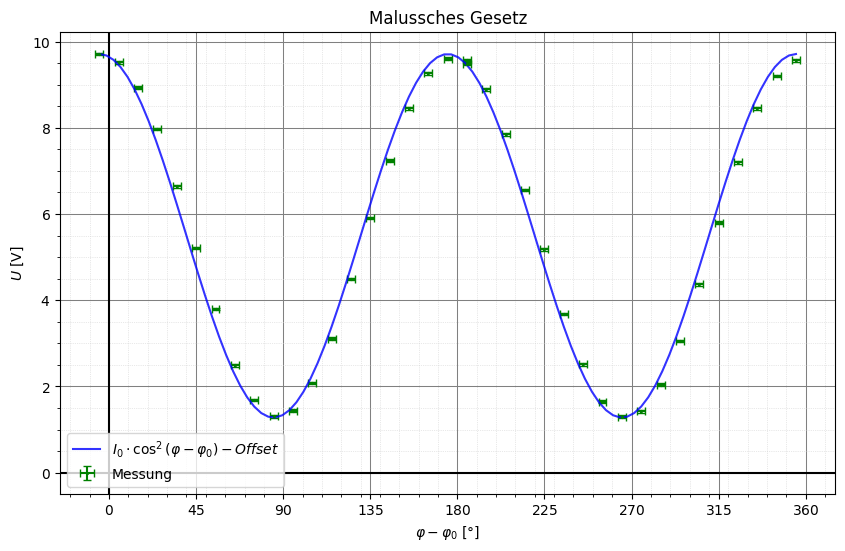

In [47]:
# Werte fuer Malus
I_0 = 9.71 - 1.28  # U_max - U_min
offset = 1.28  # U_min
phi_0 = 175/360 * 2*np.pi

geraden_fit(
    exp_nr='',
    file_n='phiA_U_Uunter_plot.txt',
    title=r'Malussches Gesetz',
    y_label=r'$U$ [V]',
    x_label=r'$\varphi - \varphi_0$ [°]',
    save=True,
    length=10,
    height=6,
    x_axis=0,
    y_axis=0,
    x_major_ticks=45,   # Hauptticks alle 10 Einheiten
    x_minor_ticks=10,    # Nebenticks alle 1 Einheit
    y_major_ticks=2,
    y_minor_ticks=0.5,
    legendlocation='lower left',
    y_labels=['Messung'],  # Provide labels for each dataset
    # y_markers=['o'],       # Optional: specify markers
    y_colors=['green'], # Optional: specify colors
    x_decimal_places=0,
    y_decimal_places=1,
    plot_errors =  True,
    size = 1.3,
    Malus=True
)

[-60. -59. -57. -60. -61.]
[-78. -76. -80. -79. -78.]
[120. 121. 123. 120. 119.]
[102. 104. 100. 101. 102.]
0
Fit-Ergebnisse für 1:
Schwerpunkt: (0.0000036928932773201584 ± 0, 55.0 ± 1.4)
Steigung: -10500000 ± 1300000
Y-Achsenabschnitt: 94 ± 5



C:\Users\Dejan\AppData\Local\Temp\ipykernel_12076\2955284771.py:158: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10')


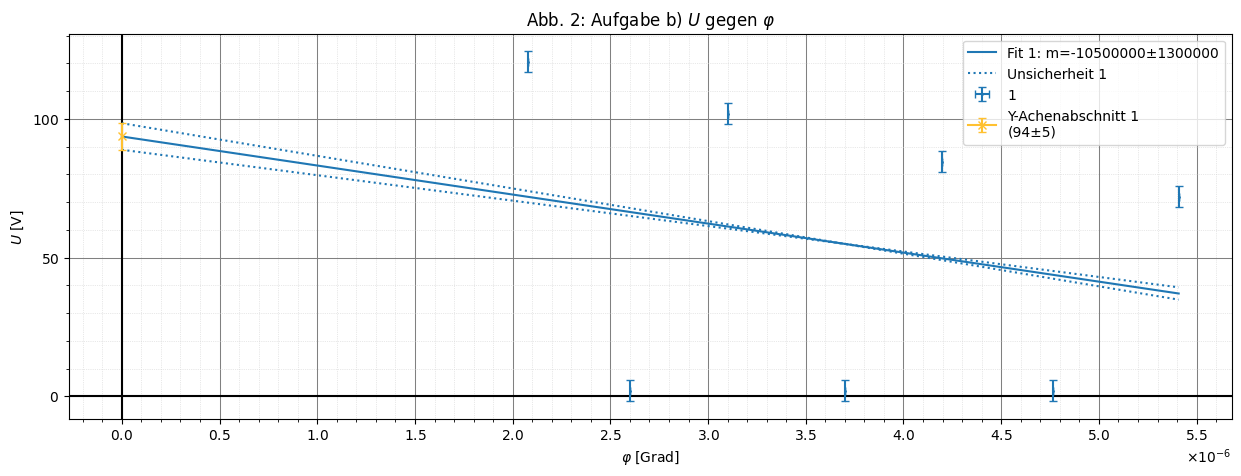

In [54]:
# Daten laden
data = np.loadtxt('b/b_roh.txt', ndmin=1)
nm694, nm620, nm568, nm520, nm490, nm460, nm430 = data[:, 0], data[:, 1], data[:, 2], data[:, 3], data[:, 4], data[:, 5], data[:, 6]
y_data = data[:, 2:]
print(nm694)
print(nm568)
# First we need to set all negative angles a to 90 - a
nm694 = np.where(nm694 < 0, 180 + nm694, nm694)
nm620 = np.where(nm620 < 0, 180 + nm620, nm620)
nm568 = np.where(nm568 < 0, 180 + nm568, nm568)
nm520 = np.where(nm520 < 0, 180 + nm520, nm520)
nm490 = np.where(nm490 < 0, 180 + nm490, nm490)
nm460 = np.where(nm460 < 0, 180 + nm460, nm460)
nm430 = np.where(nm430 < 0, 180 + nm430, nm430)
#how does np.where work? It takes an array and a condition. If the condition is true, it returns the first value, if it is false, it returns the second value

print(nm694)
print(nm568)
#calculate the mean values
nm694_mean = np.mean(nm694)
nm620_mean = np.mean(nm620)
nm568_mean = np.mean(nm568)
nm520_mean = np.mean(nm520)
nm490_mean = np.mean(nm490)
nm460_mean = np.mean(nm460)
nm430_mean = np.mean(nm430)

#I now need this to be incoorperated into the geraden_fit function. For that, I need to save the mean values in a file with their errors in this format:
#1/wavelength**2 null mean_value error
#I will do this now
#mean_values = np.array([nm694_mean, nm620_mean, nm568_mean, nm520_mean, nm490_mean, nm460_mean, nm430_mean])
#errors = np.array([1/(np.sqrt(7))*10, 1/(np.sqrt(7))*10, 1/(np.sqrt(7))*10, 1/(np.sqrt(7))*10, 1/(np.sqrt(7))*10, 1/(np.sqrt(7))*10, 1/(np.sqrt(7))*10])
#np.savetxt('b_mean.txt', np.column_stack([mean_values, errors]), fmt='%.18e', delimiter=' ', header='mean_values errors')

#You need to do the saving again, because we need the 1/lambda**2 values
mean_values = np.array([nm694_mean, nm620_mean, nm568_mean, nm520_mean, nm490_mean, nm460_mean, nm430_mean])
errors = np.array([10/np.sqrt(7), 10/np.sqrt(7), 10/np.sqrt(7), 10/np.sqrt(7), 10/np.sqrt(7), 10/np.sqrt(7), 10/np.sqrt(7)])
inverse_wavelengths_squared = np.array([1/(694**2), 1/(620**2), 1/(568**2), 1/(520**2), 1/(488**2), 1/(458**2), 1/(430**2)])
null = np.zeros(7)
np.savetxt('b_mean.txt', np.column_stack([inverse_wavelengths_squared, null, mean_values, errors]), fmt='%.18e', delimiter=' ', header='mean_values errors inverse_wavelengths_squared null')

geraden_fit(
    exp_nr='',
    file_n='b_mean.txt',
    title=r'Abb. 2: Aufgabe b) $U$ gegen $\varphi$',
    y_label=r'$U$ [V]',
    x_label=r'$\varphi$ [Grad]',
    save=True,
    linear_fit=True,
    plot_y_inter=True,
    x_major_ticks=0.0000005,
    x_minor_ticks=0.0000001,
    y_major_ticks=50,
    y_minor_ticks=10)


C:\Users\Dejan\AppData\Local\Temp\ipykernel_12076\2955284771.py:158: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10')


0
Fit-Ergebnisse für 1:
Schwerpunkt: (0.0000036928932773201584 ± 0, 103.6 ± 1.4)
Steigung: 25500000 ± 1300000
Y-Achsenabschnitt: 9 ± 5



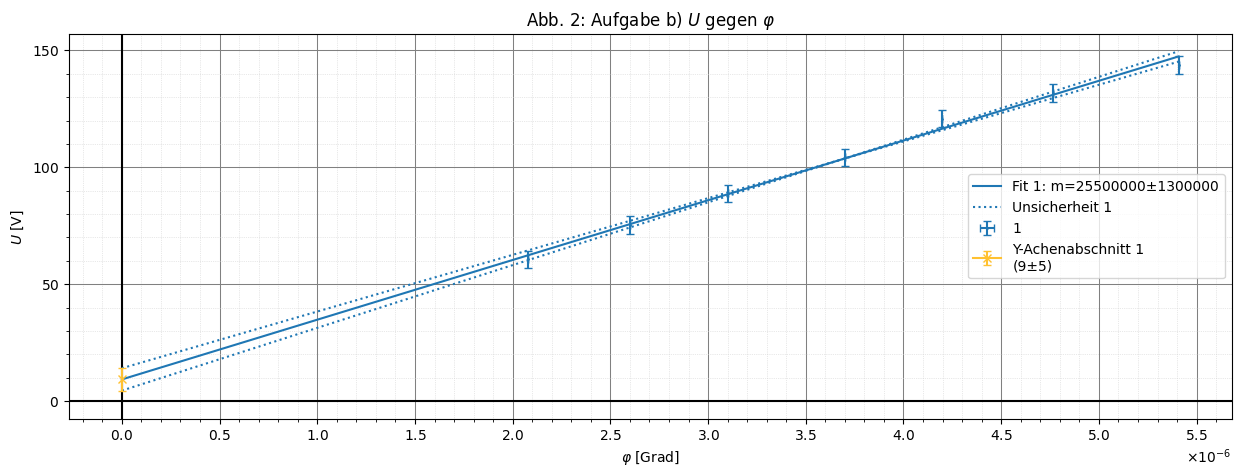

In [55]:
geraden_fit(
    exp_nr='',
    file_n='b_mean.txt',
    title=r'Abb. 2: Aufgabe b) $U$ gegen $\varphi$',
    y_label=r'$U$ [V]',
    x_label=r'$\varphi$ [Grad]',
    save=True,
    linear_fit=True,
    plot_y_inter=True,
    x_major_ticks=0.0000005,
    x_minor_ticks=0.0000001,
    y_major_ticks=50,
    y_minor_ticks=10)
